## Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks price data
* Calculate different features and indicators on each stock
* Aggregate on monthly level and filter top 150 most liquid stocks
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustring Algorithm to group simular assets based on their features.
* For each month select assets based on the cluster and form a portfolio on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns

### 1 Download/Load SP500 stocks price data

In [256]:
from statsmodels.regression.rolling import RollingOLS

import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [257]:
sp500           = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0] # import data
sp500['Symbol'] = sp500['Symbol'].str.replace(".", "-") # clean data 

symbols_list    = sp500['Symbol'].unique().tolist() #notice:these stock names are not survivor-bias free

end_date        = '2023-09-27'
start_date      = pd.to_datetime(end_date) - pd.DateOffset(365*8) #use 8 years data

df              = yf.download(tickers=symbols_list, start = start_date, end = end_date).stack()




[*********************100%%**********************]  503 of 503 completed


3 Failed downloads:
['GEV', 'VLTO', 'SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


In [258]:
df

Adj Close       Close        High         Low        Open  \
Date                                                                          
2015-09-29 A      31.483553   33.740002   34.060001   33.240002   33.360001   
           AAL    37.361626   39.180000   39.770000   38.790001   39.049999   
           AAPL   24.684568   27.264999   28.377501   26.965000   28.207500   
           ABBV   36.334900   52.790001   54.189999   51.880001   53.099998   
           ABT    33.478703   39.500000   40.150002   39.029999   39.259998   
...                     ...         ...         ...         ...         ...   
2023-09-26 XYL    88.968475   89.519997   90.849998   89.500000   90.379997   
           YUM   122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH   111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA  223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS   176.048233  176.869995  178.449997  176.270004  176.580002   

                      Volume  
Date                          
2015-09-29 A       2252400.0  
           AAL     7478800.0  
           AAPL  293461600.0  
           ABBV   12842800.0  
           ABT    12287500.0  
...                      ...  
2023-09-26 XYL     1322400.0  
           YUM     1500600.0  
           ZBH     3610500.0  
           ZBRA     355400.0  
           ZTS     1463200.0  

[989155 rows x 6 columns]

In [259]:
df.index.names = ['date','ticker']
df.columns     = df.columns.str.lower()
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483553   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361626   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684568   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334900   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478703   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968475   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     176.048233  176.869995  178.449997  176.270004  176.580002   

                        volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[989155 rows x 6 columns]

### 2 Calculate features and technical indicators for each stock

* Garman - Klass Volatility: a meansure of intra-day volatility

$$Garman-Klass Volatility = \frac{(ln(High)-ln(Low))^2}{2} - (2ln(2)-1)*(ln(Adj Close) - ln(Open))^2$$

* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [260]:
# Generate Garman Klass Volatility column
df["garman_klass_vol"] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# Generate RSI column
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Generate Bollinger Bands: low, middle, and high
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

# Generate ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low  = stock_data['low'],
                        close = stock_data['close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# Generate MCAD
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

# Generate dollar volumn
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483553   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361626   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684568   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334900   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478703   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968475   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     176.048233  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000998        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005572        NaN       NaN   
           ABBV     12842800.0         -0.054655        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0          0.000016  26.146758  4.488345   
           YUM       1500600.0          0.000002  36.057149  4.816569   
           ZBH       3610500.0          0.000099  31.893258  4.748085   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000072  42.623457  5.158939   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.913555  
           AAL          NaN       NaN       NaN       NaN     279.420126  
           AAPL         NaN       NaN       NaN       NaN    7243.972939  
           ABBV         NaN       NaN       NaN       NaN     466.641852  
           ABT          NaN       NaN       NaN       NaN     411.369558  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.570270  4.652196  0.033800 -2.159188     117.651912  
           YUM     4.846536  4.876502  0.142547 -1.363695     184.291052  
           ZBH     4.787752  4.827420 -0.381708 -0.881067     403.591519  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.217753  5.276568  0.651515 -1.188278     257.593775  

[989155 rows x 14 columns]

<AxesSubplot: xlabel='date'>

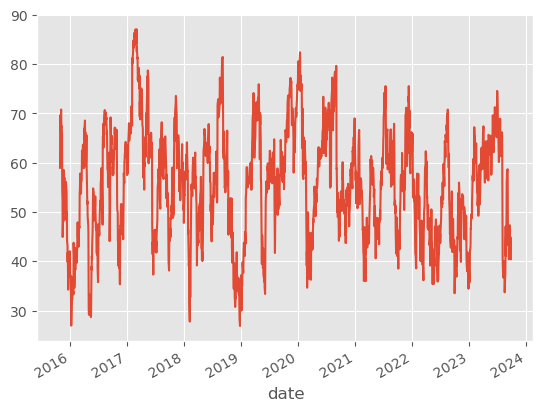

In [261]:
df.xs('AAPL',level=1)['rsi'].plot()

### 3 Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.


In [262]:
# Define the last columns
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume','open',
                                                         'high','low','close']]

data=(pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                 df.unstack()[last_cols].resample('M').last().stack('ticker')],
                 axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2015-11-30 A          135.992822   39.023190 -1.033887  3.690888  3.545992   
           AAL        287.915796   39.429935  0.190822  3.827636  3.672028   
           AAPL      4029.441740   26.890560 -0.967900  3.369611  3.282983   
           ABBV       337.563912   40.393536 -0.526809  3.823191  3.726695   
           ABT        211.659053   38.293571 -1.064842  3.699763  3.656055   
...                          ...         ...       ...       ...       ...   
2023-09-30 OTIS       154.983159   78.671936 -1.028320  4.464683  4.374104   
           ABNB      1633.500725  132.279999 -1.006939  5.024801  4.857047   
           CEG        196.971017  108.026909 -0.436215  4.734007  4.653660   
           GEHC       212.350629   66.153511 -0.893478  4.270855  4.155782   
           KVUE       677.910277   20.218124 -0.899746  3.174263  3.024299   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2015-11-30 A       3.618440         -0.001992  0.567157  73.421584  
           AAL     3.749832         -0.000966 -0.418772  40.719014  
           AAPL    3.326297         -0.003209 -0.142790  55.537346  
           ABBV    3.774943         -0.059549  0.145678  49.376893  
           ABT     3.677909         -0.011216  0.335557  56.962558  
...                     ...               ...       ...        ...  
2023-09-30 OTIS    4.419394         -0.000020 -1.534536  33.116247  
           ABNB    4.940924          0.000213 -0.037854  44.494127  
           CEG     4.693834          0.000171  0.366876  55.245466  
           GEHC    4.213319          0.000185 -1.116463  40.922336  
           KVUE    3.099281          0.000032 -1.435621  35.706337  

[46704 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering

In [263]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume','dollar_vol_rank'],axis=1)
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-10-31 AAL      39.134319  0.402199  3.706314  3.604673  3.655493   
           AAPL     26.248024 -1.038688  3.353305  3.295542  3.324423   
           ABBV     40.245117 -0.893132  3.861774  3.753446  3.807610   
           ABT      34.293446 -1.035224  3.655580  3.554632  3.605106   
           ACN     103.569626 -0.996806  4.660617  4.637342  4.648980   
...                       ...       ...       ...       ...       ...   
2023-09-30 WMT      53.783062 -0.196381  4.023309  3.988367  4.005838   
           XOM     114.292961  0.601335  4.775304  4.695106  4.735205   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   
           ABNB    132.279999 -1.006939  5.024801  4.857047  4.940924   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2016-10-31 AAL            -0.000176  1.131594  62.203520  
           AAPL           -0.002384 -0.195978  49.891039  
           ABBV           -0.046691 -0.760593  27.477745  
           ABT            -0.007492 -0.650889  38.008796  
           ACN            -0.004643 -0.135457  53.823663  
...                             ...       ...        ...  
2023-09-30 WMT            -0.000011  0.399459  54.722560  
           XOM             0.000026  1.400623  59.440189  
           MRNA            0.000146 -0.376899  38.747314  
           UBER            0.000441 -0.133973  45.005268  
           ABNB            0.000213 -0.037854  44.494127  

[12516 rows x 8 columns]

### 4 Calculate Monthly Returns for different time horizons as features

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historial returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [264]:
g = df.xs('AAPL', level=1)

def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1,2,3,6,9,12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                                  .pct_change(lag)
                                  .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                         upper=x.quantile(1-outlier_cutoff)))
                                  .add(1)
                                  .pow(1/lag)
                                  .sub(1))
    return df

data = data.groupby(level=1, group_keys = False).apply(calculate_returns).dropna()
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-10-31 AAL      45.534164  1.011062  3.994389  3.849110  3.921750   
           AAPL     39.767769 -0.906642  3.689797  3.596048  3.642923   
           ABBV     67.491142  0.375557  4.289423  4.196702  4.243063   
           ABT      48.493378 -1.040044  3.939707  3.892568  3.916137   
           ACN     129.399704 -0.986514  4.882034  4.802675  4.842354   
...                       ...       ...       ...       ...       ...   
2023-09-30 WMT      53.783062 -0.196381  4.023309  3.988367  4.005838   
           XOM     114.292961  0.601335  4.775304  4.695106  4.735205   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   
           ABNB    132.279999 -1.006939  5.024801  4.857047  4.940924   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-10-31 AAL            -0.000363 -0.018699  41.051779  -0.014108   
           AAPL           -0.000998 -0.039275  69.196696   0.096808   
           ABBV           -0.034008  0.473814  55.247836   0.022728   
           ABT            -0.005190  0.276133  53.844907   0.021276   
           ACN            -0.003925  0.352343  69.364969   0.064180   
...                             ...       ...        ...        ...   
2023-09-30 WMT            -0.000011  0.399459  54.722560  -0.000676   
           XOM             0.000026  1.400623  59.440189   0.046947   
           MRNA            0.000146 -0.376899  38.747314  -0.132219   
           UBER            0.000441 -0.133973  45.005268  -0.062672   
           ABNB            0.000213 -0.037854  44.494127   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10340 rows x 14 columns]

### 5 Download Fama-French Factors and Calculate Rolling Factor Betas

* We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression
* The five Fama-French factors, namely "Market Riskj", "Size", "Value", "Operating Profitability", and "Investment" have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. hence, it is natural to include past factor exposures as financial features in modles.
* We can access the historical factor returns using the pandas-datareader and estimate histoprical exposures using the RollingOLS rolling linear regression.

In [265]:
factor_data = web.DataReader('F-F_research_Data_5_Factors_2x3',
                              'famafrench',
                              start='2010')[0].drop('RF',axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data

#join this data to month return

factor_data = factor_data.join(data['return_1m']).sort_index()

# double check with apple  as example
factor_data.xs('AAPL',level=1).head()


,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2017-10-31,0.0225,-0.0194,0.0020,0.0093,-0.0325,0.096808
2017-11-30,0.0312,-0.0033,-0.0003,0.0316,-0.0005,0.020278
2017-12-31,0.0106,-0.0107,0.0006,0.0074,0.0169,-0.015246
2018-01-31,0.0557,-0.0318,-0.0129,-0.0076,-0.0096,-0.010637
2018-02-28,-0.0365,0.0032,-0.0104,0.0052,-0.0237,0.068185


In [266]:
# double check with microsoft as example
factor_data.xs('MSFT',level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2017-10-31,0.0225,-0.0194,0.0020,0.0093,-0.0325,0.116660
2017-11-30,0.0312,-0.0033,-0.0003,0.0316,-0.0005,0.016984
2017-12-31,0.0106,-0.0107,0.0006,0.0074,0.0169,0.016276
2018-01-31,0.0557,-0.0318,-0.0129,-0.0076,-0.0096,0.110709
2018-02-28,-0.0365,0.0032,-0.0104,0.0052,-0.0237,-0.008415


* Filter out stocks with less than 10 months of data

In [267]:
# check how many months' data we have under each stocks
factor_data.groupby(level=1).size()

ticker
AAL     72
AAPL    72
ABBV    72
ABNB    10
ABT     72
        ..
WFC     72
WMT     72
WYNN    70
XOM     72
YUM      2
Length: 176, dtype: int64

In [268]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >=10]
valid_stocks

ticker
AAL     72
AAPL    72
ABBV    72
ABNB    10
ABT     72
        ..
WDC     56
WFC     72
WMT     72
WYNN    70
XOM     72
Length: 168, dtype: int64

In [269]:
# filt out stocks we are going to remove
# factor_data = factor_data[~factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

# filt out stocks we are going to keep

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10300 rows x 6 columns]

* now we are ready to calculate the Rolling Factor Betas

In [270]:
betas = (factor_data.groupby(level=1,
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const',axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456426 -0.445902 -0.312668 -0.079430  0.800286
           VZ      0.332655 -0.165647  0.267345  0.310366  0.106901
           WFC     1.121746  0.300521  2.061532 -0.439489 -1.517557
           WMT     0.700557 -0.315600 -0.413433 -0.142906  0.508471
           XOM     0.983510 -1.093759  1.756776 -0.640867 -0.368454

[10300 rows x 5 columns]

In [271]:
# we have to shift betas, because we only know the betas after the month end, after all data of the month observed.
# therefore, we will shift all betas one months forward before we join the batas to the data.

betas.groupby('ticker').shift()

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.504874 -0.411220 -0.481330  0.057087  0.943374
           VZ      0.302531 -0.212074  0.344590  0.318168  0.000825
           WFC     1.137640  0.314483  2.009073 -0.404337 -1.468839
           WMT     0.740056 -0.261890 -0.522678 -0.126426  0.642627
           XOM     1.005968 -1.051370  1.707833 -0.675680 -0.284024

[10300 rows x 5 columns]

In [272]:
# now the data is ready to joint the data

data = (data.join(betas.groupby('ticker').shift()))
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-10-31 AAL      45.534164  1.011062  3.994389  3.849110  3.921750   
           AAPL     39.767769 -0.906642  3.689797  3.596048  3.642923   
           ABBV     67.491142  0.375557  4.289423  4.196702  4.243063   
           ABT      48.493378 -1.040044  3.939707  3.892568  3.916137   
           ACN     129.399704 -0.986514  4.882034  4.802675  4.842354   
...                       ...       ...       ...       ...       ...   
2023-09-30 WMT      53.783062 -0.196381  4.023309  3.988367  4.005838   
           XOM     114.292961  0.601335  4.775304  4.695106  4.735205   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   
           ABNB    132.279999 -1.006939  5.024801  4.857047  4.940924   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-10-31 AAL            -0.000363 -0.018699  41.051779  -0.014108   
           AAPL           -0.000998 -0.039275  69.196696   0.096808   
           ABBV           -0.034008  0.473814  55.247836   0.022728   
           ABT            -0.005190  0.276133  53.844907   0.021276   
           ACN            -0.003925  0.352343  69.364969   0.064180   
...                             ...       ...        ...        ...   
2023-09-30 WMT            -0.000011  0.399459  54.722560  -0.000676   
           XOM             0.000026  1.400623  59.440189   0.046947   
           MRNA            0.000146 -0.376899  38.747314  -0.132219   
           UBER            0.000441 -0.133973  45.005268  -0.062672   
           ABNB            0.000213 -0.037854  44.494127   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702   
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228   
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026   
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294   
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728   
...                      ...        ...        ...        ...         ...   
2023-09-30 WMT      0.010014   0.012354   0.017574   0.016553    0.020256   
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037   
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431   
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691   
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN       NaN  
           ACN          NaN       NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...       ...  
2023-09-30 WMT     0.740056 -0.261890 -0.522678 -0.126426  0.642627  
           XOM     1.005968 -1.051370  1.707833 -0.675680 -0.284024  
           MRNA    1.155154  0.762525 -1.165677  0.590306  0.993548  
           UBER    1.078922  1.162540 -0.257003 -1.482231 -0.450323  
           ABNB         NaN       NaN       NaN       NaN       NaN  

[10340 rows x 19 columns]

In [273]:
# now fix the missing values
# the solution is to fill those NaN values with average of the respective factor,

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data.loc[:,factors] = data.groupby('ticker',group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-10-31 AAL      45.534164  1.011062  3.994389  3.849110  3.921750   
           AAPL     39.767769 -0.906642  3.689797  3.596048  3.642923   
           ABBV     67.491142  0.375557  4.289423  4.196702  4.243063   
           ABT      48.493378 -1.040044  3.939707  3.892568  3.916137   
           ACN     129.399704 -0.986514  4.882034  4.802675  4.842354   
...                       ...       ...       ...       ...       ...   
2023-09-30 WFC      40.009789 -0.558742  3.783384  3.702645  3.743015   
           WMT      53.783062 -0.196381  4.023309  3.988367  4.005838   
           XOM     114.292961  0.601335  4.775304  4.695106  4.735205   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-10-31 AAL            -0.000363 -0.018699  41.051779  -0.014108   
           AAPL           -0.000998 -0.039275  69.196696   0.096808   
           ABBV           -0.034008  0.473814  55.247836   0.022728   
           ABT            -0.005190  0.276133  53.844907   0.021276   
           ACN            -0.003925  0.352343  69.364969   0.064180   
...                             ...       ...        ...        ...   
2023-09-30 WFC             0.000016 -0.282325  40.920287  -0.015500   
           WMT            -0.000011  0.399459  54.722560  -0.000676   
           XOM             0.000026  1.400623  59.440189   0.046947   
           MRNA            0.000146 -0.376899  38.747314  -0.132219   
           UBER            0.000441 -0.133973  45.005268  -0.062672   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702   
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228   
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026   
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294   
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728   
...                      ...        ...        ...        ...         ...   
2023-09-30 WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255   
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256   
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037   
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431   
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2017-10-31 AAL     1.265664  1.314316  0.601340  0.458860  0.563293  
           AAPL    1.275750 -0.271695 -0.591144  0.647779  0.458080  
           ABBV    0.494522  0.362281 -0.033102  0.241981  0.164920  
           ABT     0.828091 -0.199021 -0.529384  0.252405  0.970210  
           ACN     1.199048 -0.166701 -0.328214  0.267789  0.168886  
...                     ...       ...       ...       ...       ...  
2023-09-30 WFC     1.137640  0.314483  2.009073 -0.404337 -1.468839  
           WMT     0.740056 -0.261890 -0.522678 -0.126426  0.642627  
           XOM     1.005968 -1.051370  1.707833 -0.675680 -0.284024  
           MRNA    1.155154  0.762525 -1.165677  0.590306  0.993548  
           UBER    1.078922  1.162540 -0.257003 -1.482231 -0.450323  

[10068 rows x 19 columns]

In [274]:
# check the result again
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10068 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'UBER')
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   adj close         10068 non-null  float64
 1   atr               10068 non-null  float64
 2   bb_high           10068 non-null  float64
 3   bb_low            10068 non-null  float64
 4   bb_mid            10068 non-null  float64
 5   garman_klass_vol  10068 non-null  float64
 6   macd              10068 non-null  float64
 7   rsi               10068 non-null  float64
 8   return_1m         10068 non-null  float64
 9   return_2m         10068 non-null  float64
 10  return_3m         10068 non-null  float64
 11  return_6m         10068 non-null  float64
 12  return_9m         10068 non-null  float64
 13  return_12m        10068 non-null  float64
 14  Mkt-RF            10068 non-null  float64
 15  SMB       

In [275]:
# we found we do not need the "adj close", so we can drop it

data = data.drop('adj close', axis=1)

In [276]:
# Now for each month, we have the top 150 liquidity stocks,
# also, we need to decide what stock to be included in our next month portfolio, 
# where we will use a ML model to predict which stock to be included (predict long portfolios)
# same, we can also use ML to decide short portfolios if needed.

### 6 For each month fit a K-Means Clustering Algorithm to group similar assets based on their features

### K-Means Clustering

* you may want to initialize predefined centroids for each cluster based on research
* For visualization purpose, we will initially rely on the "K-means++" initialization
* Then we will pre-define our centroids for each cluster

In [277]:
#generate our own initial centroids for clustering, check sklearn help doc. 

#this is to pre-define centroids for each cluster

target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [278]:
data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-10-31 AAL     1.011062  3.994389  3.849110  3.921750         -0.000363   
           AAPL   -0.906642  3.689797  3.596048  3.642923         -0.000998   
           ABBV    0.375557  4.289423  4.196702  4.243063         -0.034008   
           ABT    -1.040044  3.939707  3.892568  3.916137         -0.005190   
           ACN    -0.986514  4.882034  4.802675  4.842354         -0.003925   
...                     ...       ...       ...       ...               ...   
2023-09-30 WFC    -0.558742  3.783384  3.702645  3.743015          0.000016   
           WMT    -0.196381  4.023309  3.988367  4.005838         -0.000011   
           XOM     0.601335  4.775304  4.695106  4.735205          0.000026   
           MRNA   -0.529511  4.788149  4.582514  4.685332          0.000146   
           UBER   -0.746098  3.917801  3.806654  3.862227          0.000441   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-10-31 AAL    -0.018699  41.051779  -0.014108   0.022981  -0.023860   
           AAPL   -0.039275  69.196696   0.096808   0.015250   0.044955   
           ABBV    0.473814  55.247836   0.022728   0.098590   0.091379   
           ABT     0.276133  53.844907   0.021276   0.034308   0.034801   
           ACN     0.352343  69.364969   0.064180   0.048454   0.037203   
...                     ...        ...        ...        ...        ...   
2023-09-30 WFC    -0.282325  40.920287  -0.015500  -0.057917  -0.013554   
           WMT     0.399459  54.722560  -0.000676   0.010014   0.012354   
           XOM     1.400623  59.440189   0.046947   0.046139   0.030496   
           MRNA   -0.376899  38.747314  -0.132219  -0.086803  -0.068763   
           UBER   -0.133973  45.005268  -0.062672  -0.053920   0.008422   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275750 -0.271695   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362281   
           ABT      0.038672   0.031320    0.029294  0.828091 -0.199021   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166701   
...                      ...        ...         ...       ...       ...   
2023-09-30 WFC      0.016712   0.000702    0.003255  1.137640  0.314483   
           WMT      0.017574   0.016553    0.020256  0.740056 -0.261890   
           XOM      0.012838   0.008747    0.027037  1.005968 -1.051370   
           MRNA    -0.071952  -0.064976   -0.015431  1.155154  0.762525   
           UBER     0.057244   0.066838    0.043691  1.078922  1.162540   

                        HML       RMW       CMA  
date       ticker                                
2017-10-31 AAL     0.601340  0.458860  0.563293  
           AAPL   -0.591144  0.647779  0.458080  
           ABBV   -0.033102  0.241981  0.164920  
           ABT    -0.529384  0.252405  0.970210  
           ACN    -0.328214  0.267789  0.168886  
...                     ...       ...       ...  
2023-09-30 WFC     2.009073 -0.404337 -1.468839  
           WMT    -0.522678 -0.126426  0.642627  
           XOM     1.707833 -0.675680 -0.284024  
           MRNA   -1.165677  0.590306  0.993548  
           UBER   -0.257003 -1.482231 -0.450323  

[10068 rows x 18 columns]

In [279]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                          random_state=0,
                          init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date',group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-10-31 AAL     1.011062  3.994389  3.849110  3.921750         -0.000363   
           AAPL   -0.906642  3.689797  3.596048  3.642923         -0.000998   
           ABBV    0.375557  4.289423  4.196702  4.243063         -0.034008   
           ABT    -1.040044  3.939707  3.892568  3.916137         -0.005190   
           ACN    -0.986514  4.882034  4.802675  4.842354         -0.003925   
...                     ...       ...       ...       ...               ...   
2023-09-30 WFC    -0.558742  3.783384  3.702645  3.743015          0.000016   
           WMT    -0.196381  4.023309  3.988367  4.005838         -0.000011   
           XOM     0.601335  4.775304  4.695106  4.735205          0.000026   
           MRNA   -0.529511  4.788149  4.582514  4.685332          0.000146   
           UBER   -0.746098  3.917801  3.806654  3.862227          0.000441   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-10-31 AAL    -0.018699  41.051779  -0.014108   0.022981  -0.023860   
           AAPL   -0.039275  69.196696   0.096808   0.015250   0.044955   
           ABBV    0.473814  55.247836   0.022728   0.098590   0.091379   
           ABT     0.276133  53.844907   0.021276   0.034308   0.034801   
           ACN     0.352343  69.364969   0.064180   0.048454   0.037203   
...                     ...        ...        ...        ...        ...   
2023-09-30 WFC    -0.282325  40.920287  -0.015500  -0.057917  -0.013554   
           WMT     0.399459  54.722560  -0.000676   0.010014   0.012354   
           XOM     1.400623  59.440189   0.046947   0.046139   0.030496   
           MRNA   -0.376899  38.747314  -0.132219  -0.086803  -0.068763   
           UBER   -0.133973  45.005268  -0.062672  -0.053920   0.008422   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275750 -0.271695   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362281   
           ABT      0.038672   0.031320    0.029294  0.828091 -0.199021   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166701   
...                      ...        ...         ...       ...       ...   
2023-09-30 WFC      0.016712   0.000702    0.003255  1.137640  0.314483   
           WMT      0.017574   0.016553    0.020256  0.740056 -0.261890   
           XOM      0.012838   0.008747    0.027037  1.005968 -1.051370   
           MRNA    -0.071952  -0.064976   -0.015431  1.155154  0.762525   
           UBER     0.057244   0.066838    0.043691  1.078922  1.162540   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601340  0.458860  0.563293        1  
           AAPL   -0.591144  0.647779  0.458080        3  
           ABBV   -0.033102  0.241981  0.164920        2  
           ABT    -0.529384  0.252405  0.970210        2  
           ACN    -0.328214  0.267789  0.168886        3  
...                     ...       ...       ...      ...  
2023-09-30 WFC     2.009073 -0.404337 -1.468839        1  
           WMT    -0.522678 -0.126426  0.642627        3  
           XOM     1.707833 -0.675680 -0.284024        3  
           MRNA   -1.165677  0.590306  0.993548        1  
           UBER   -0.257003 -1.482231 -0.450323        2  

[10068 rows x 19 columns]

In [280]:
# visualization clustering job with scatter plot

def plot_clusters(data):
    
    cluster_0 = data[data['cluster'] == 0] #select the stock's first cluster, which is the ATR
    cluster_1 = data[data['cluster'] == 1] #select the stock's second cluster, which is the rsi
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]
    
    plt.scatter(cluster_0.iloc[:,0], cluster_0.iloc[:,6], color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0], cluster_1.iloc[:,6], color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0], cluster_2.iloc[:,6], color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0], cluster_3.iloc[:,6], color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

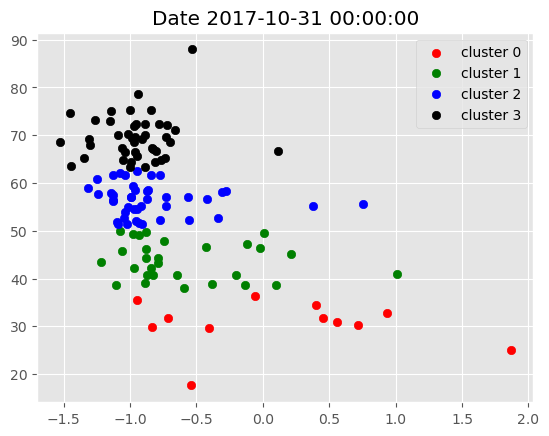

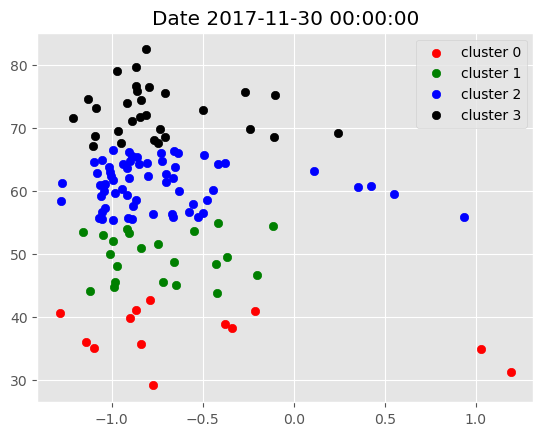

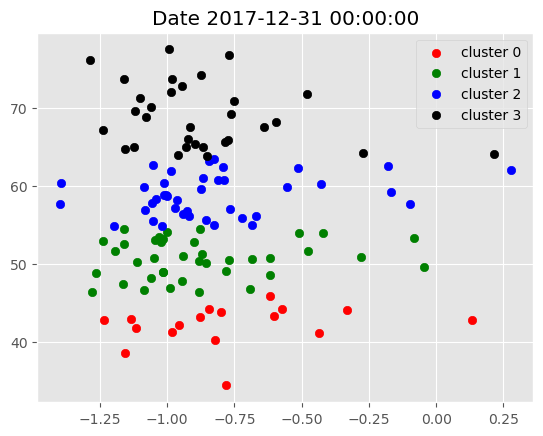

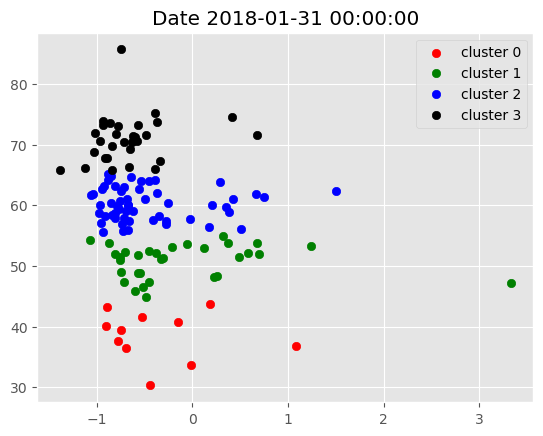

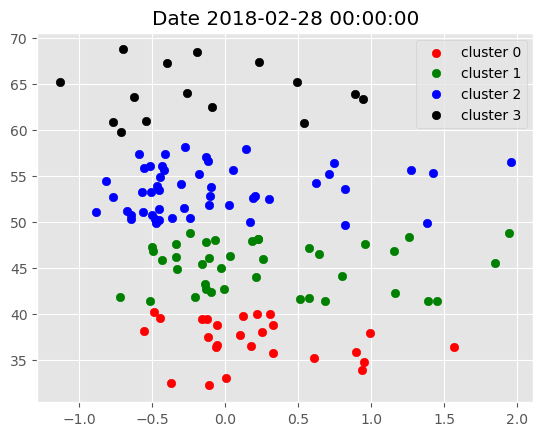

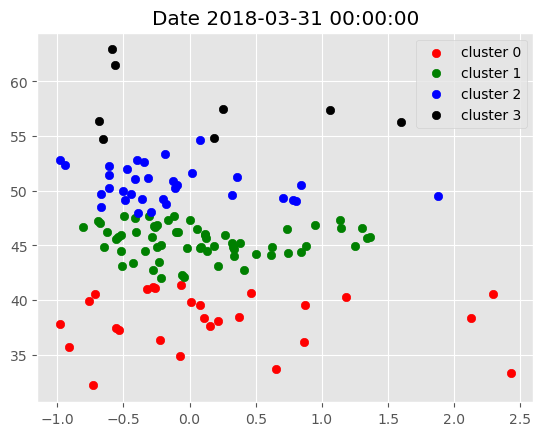

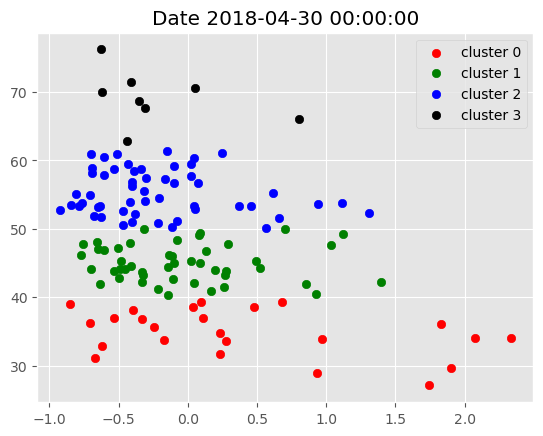

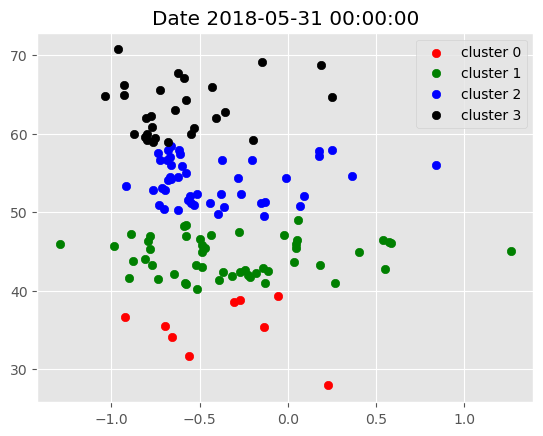

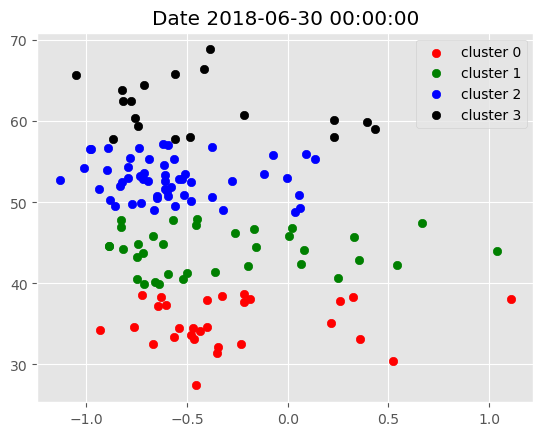

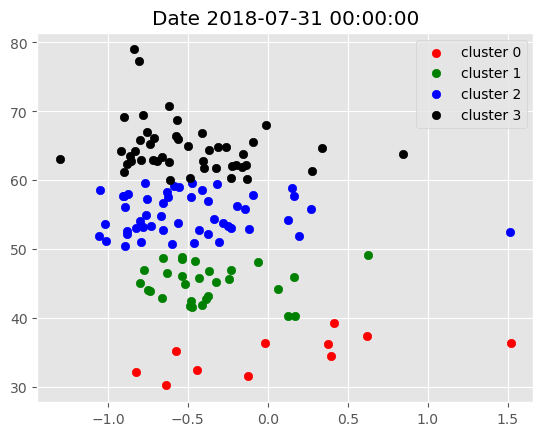

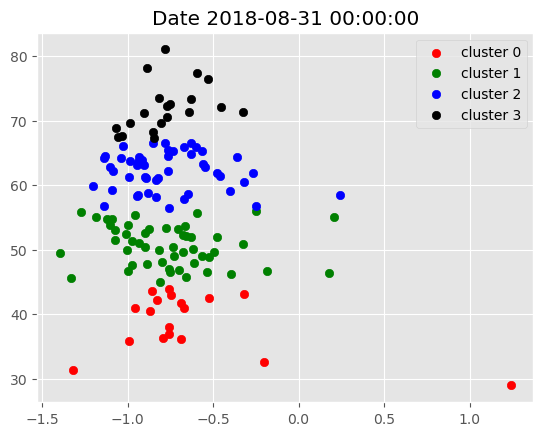

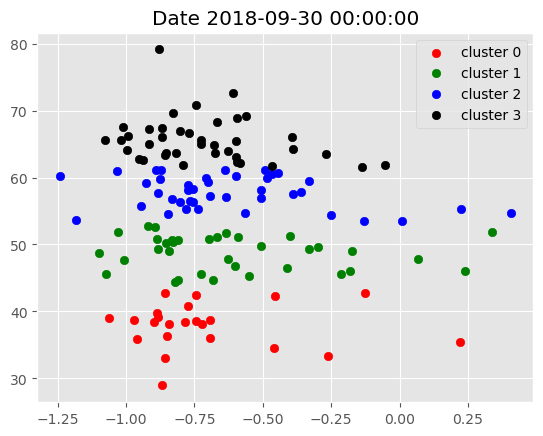

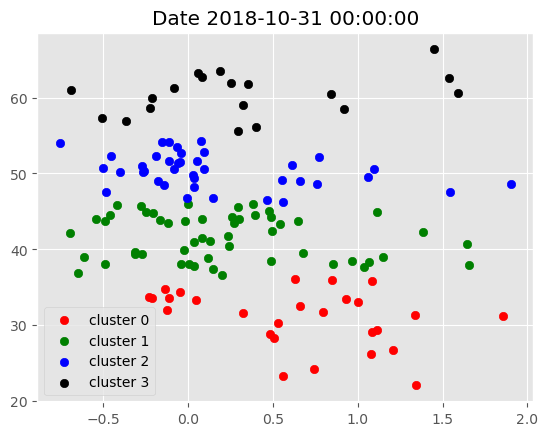

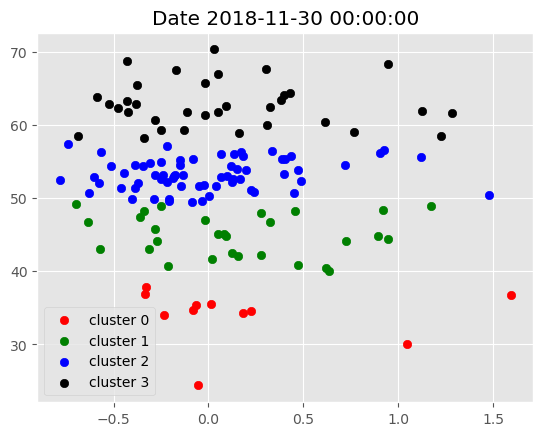

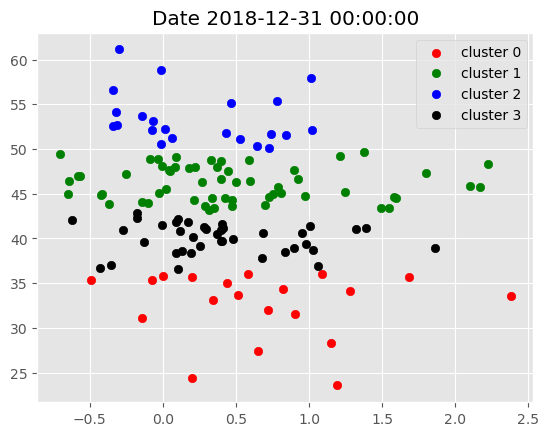

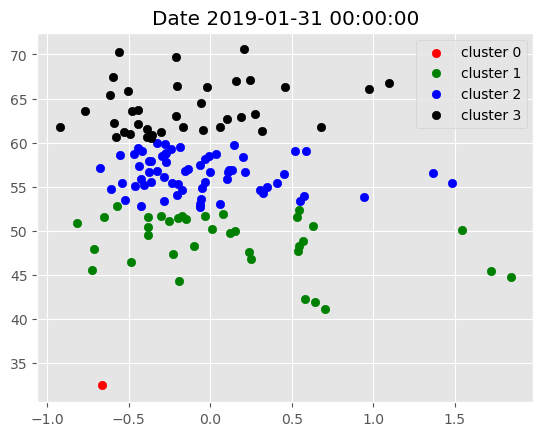

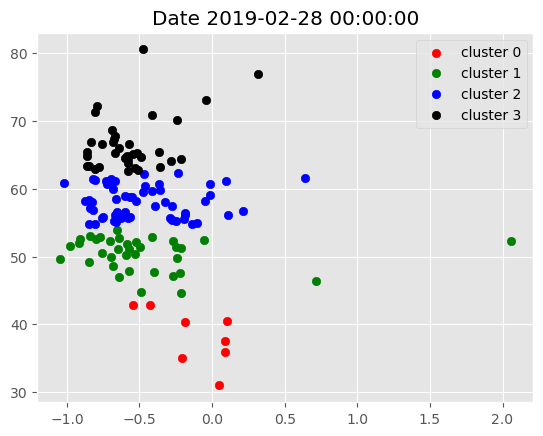

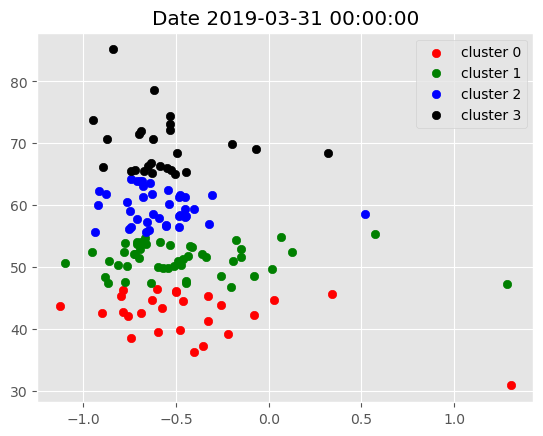

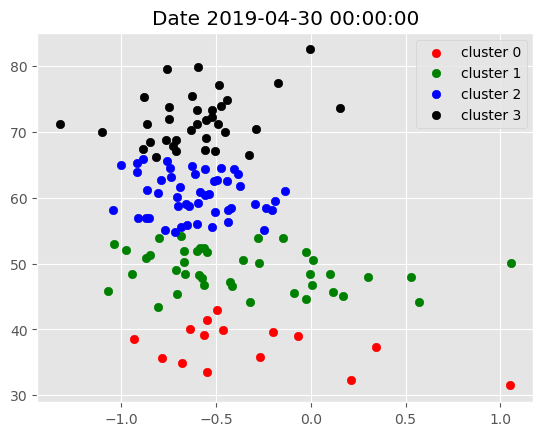

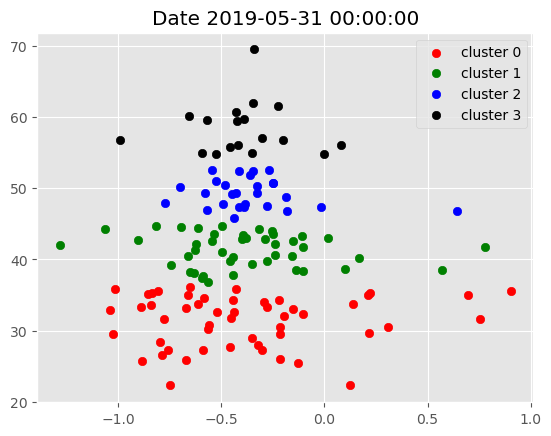

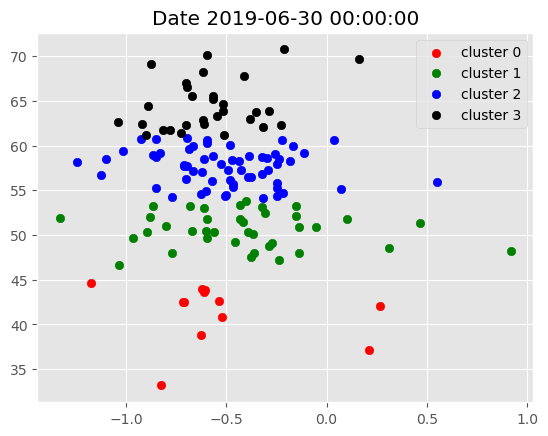

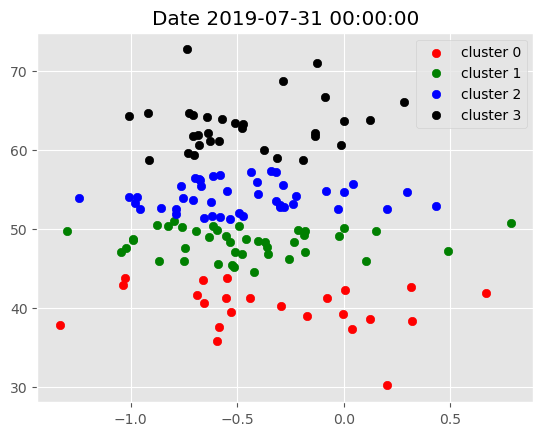

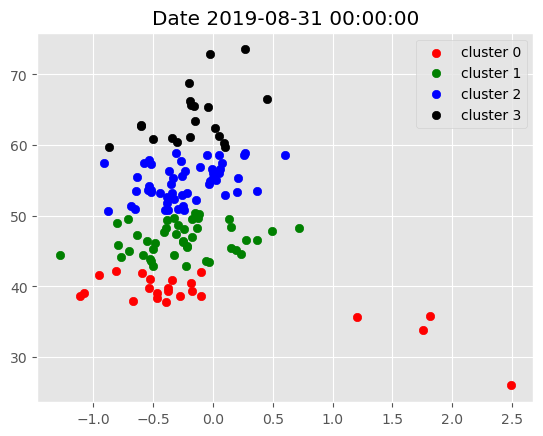

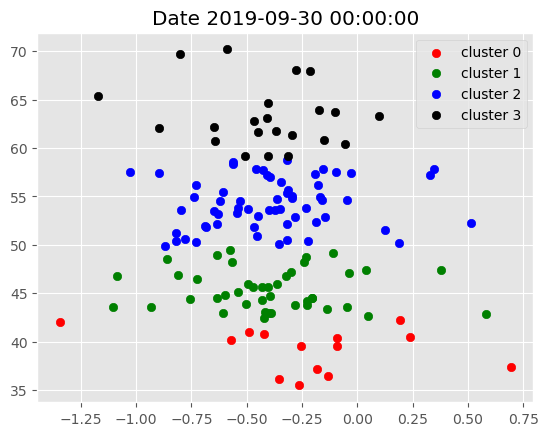

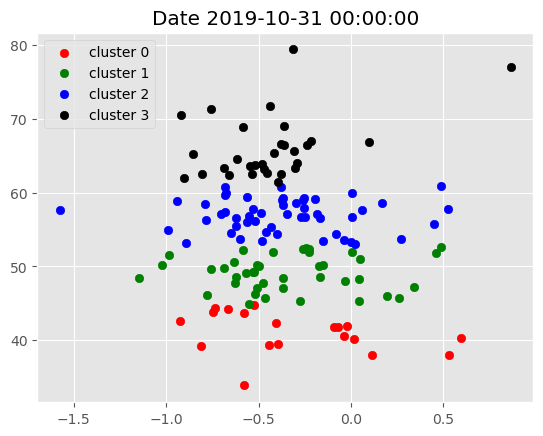

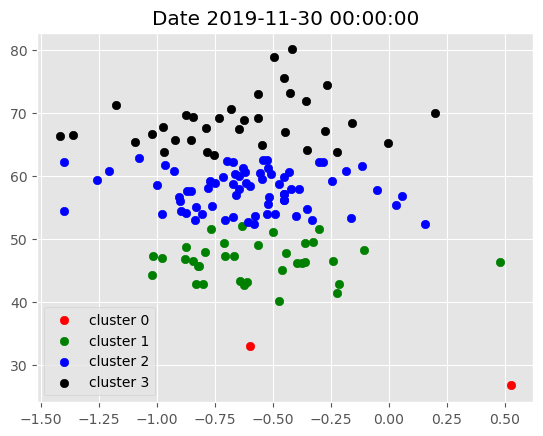

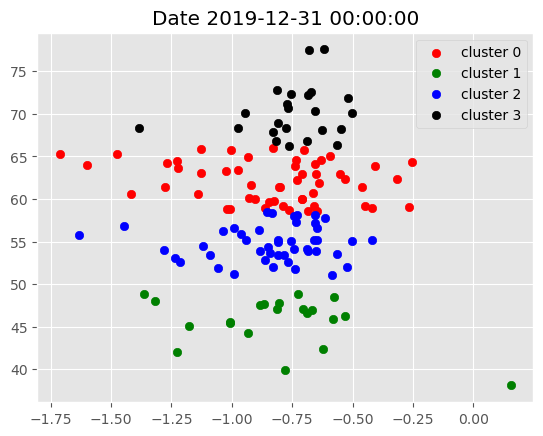

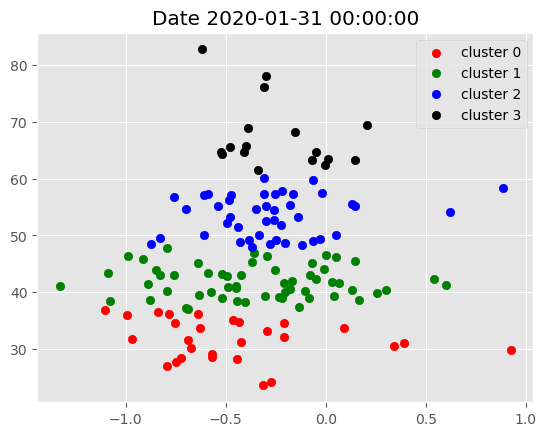

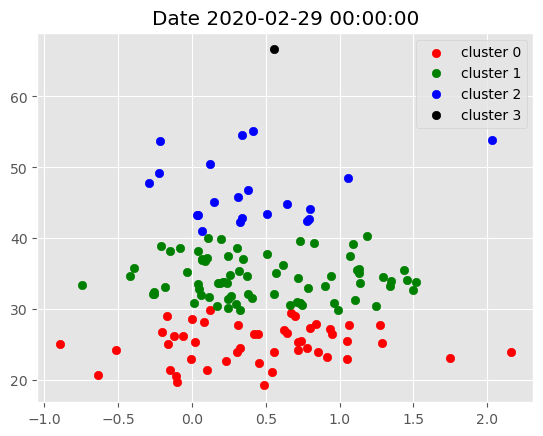

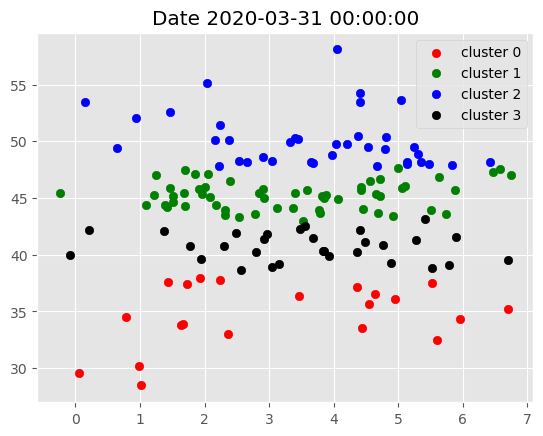

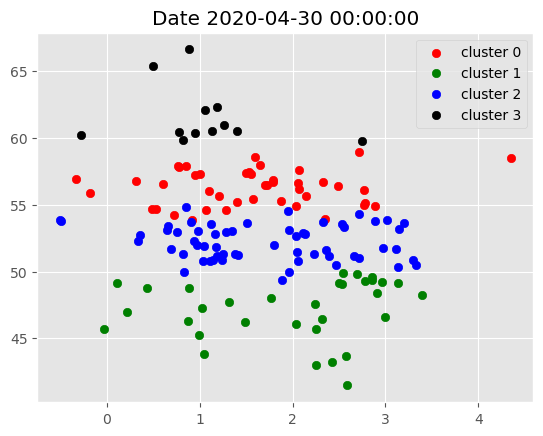

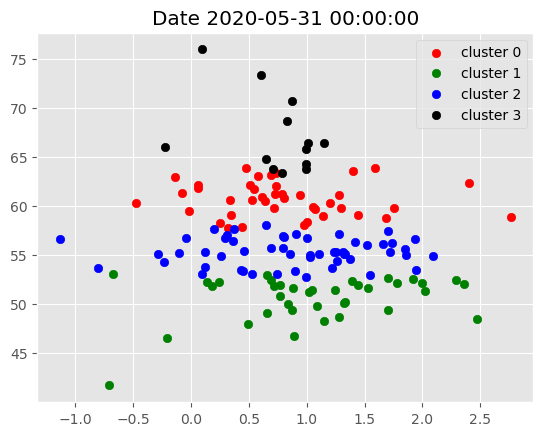

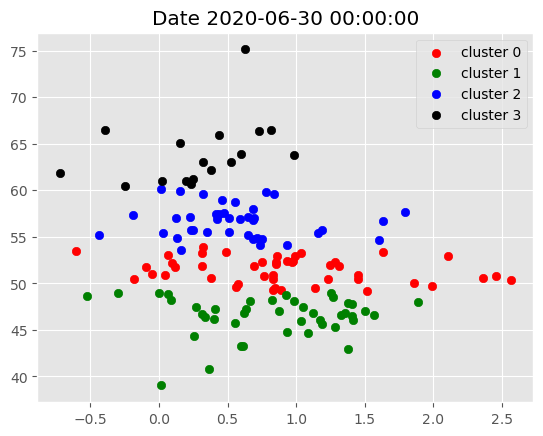

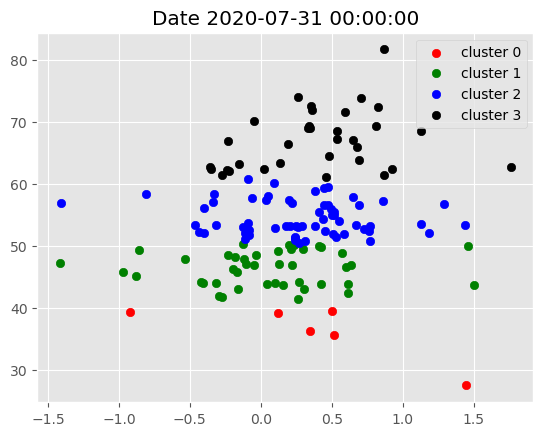

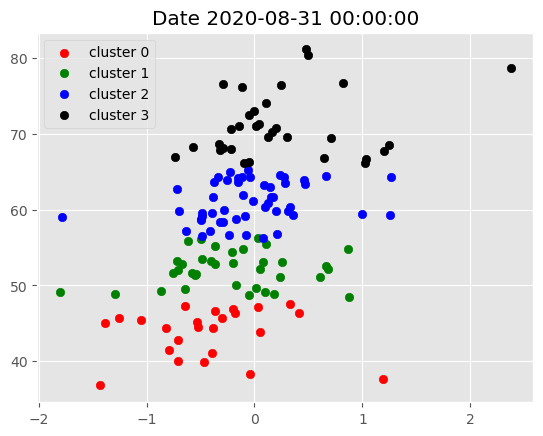

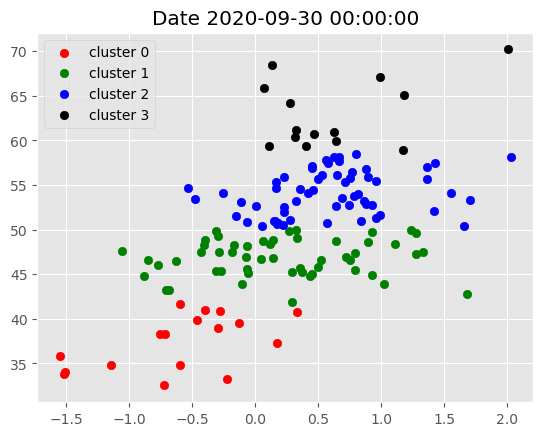

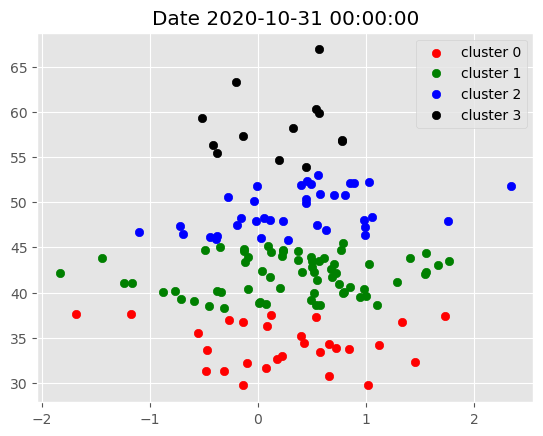

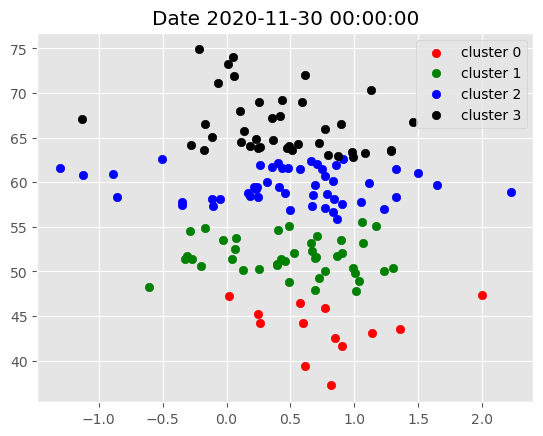

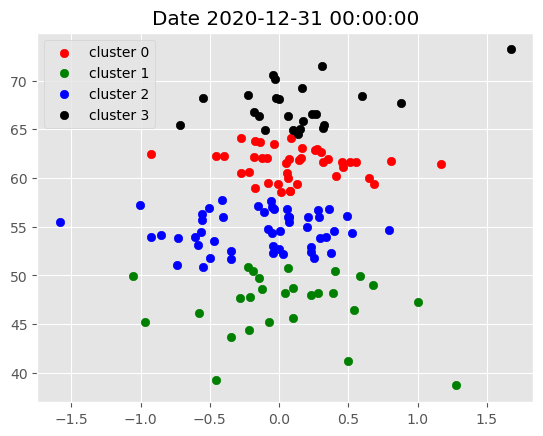

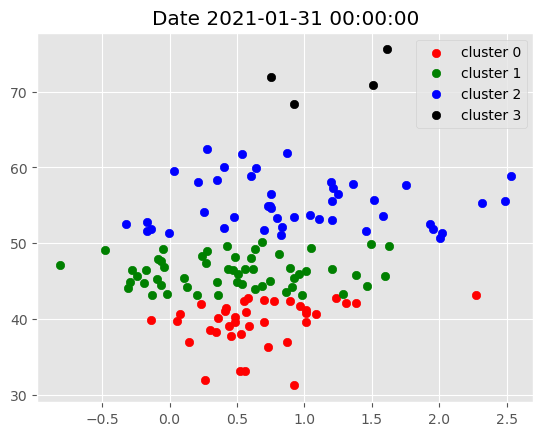

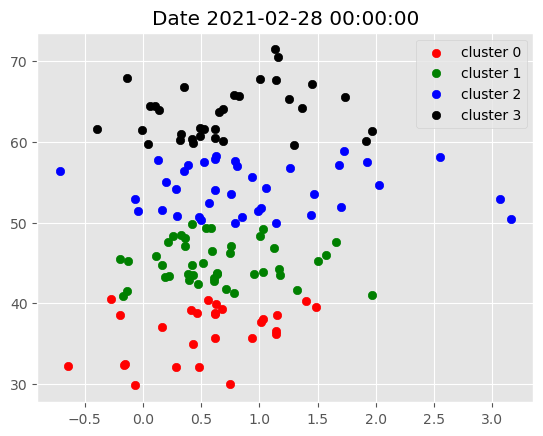

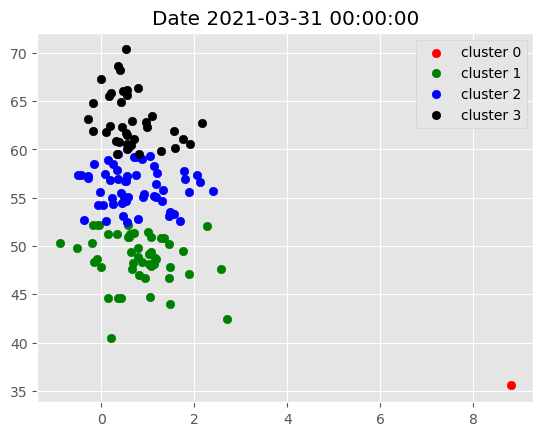

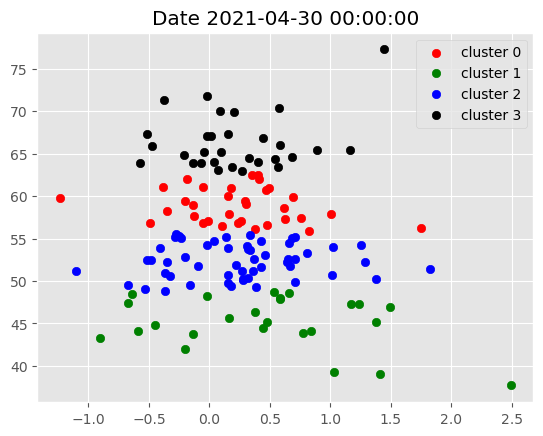

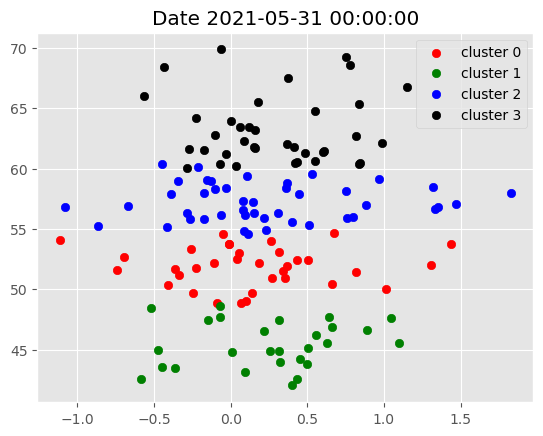

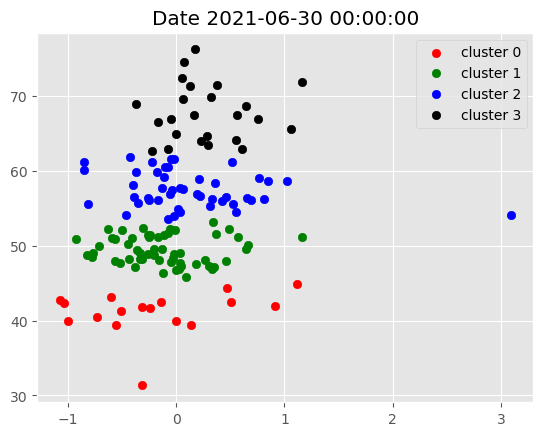

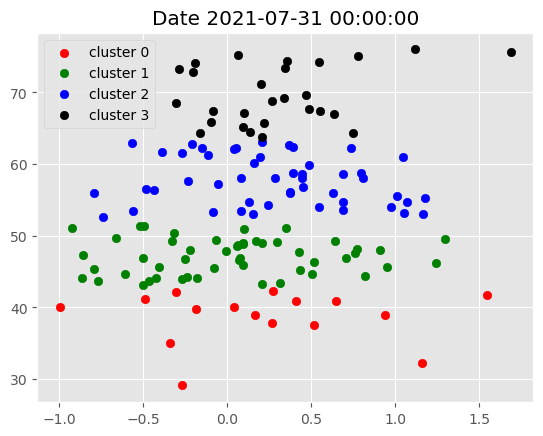

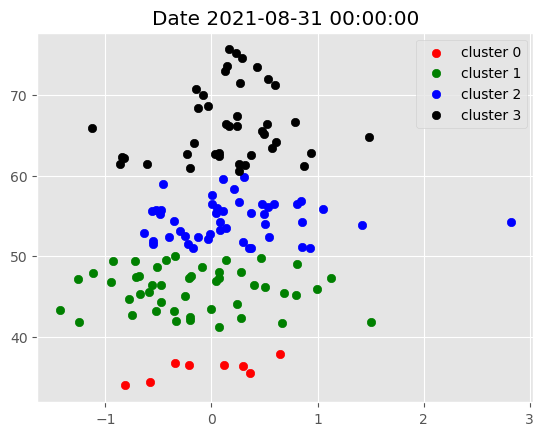

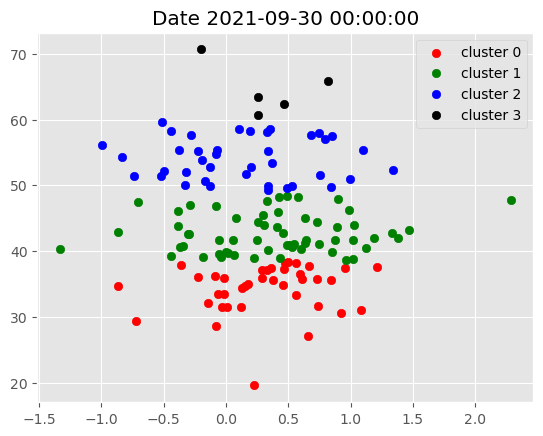

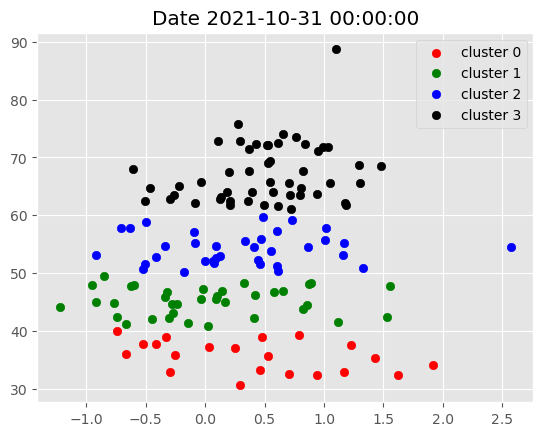

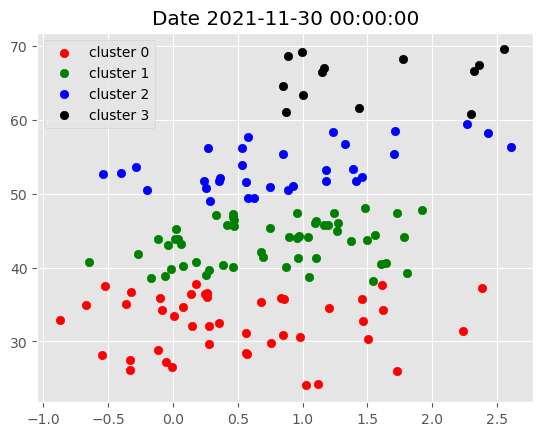

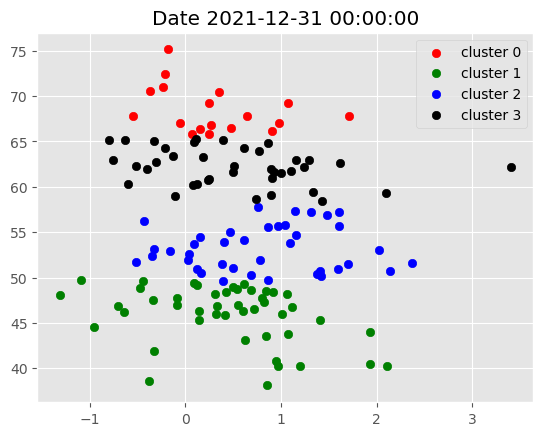

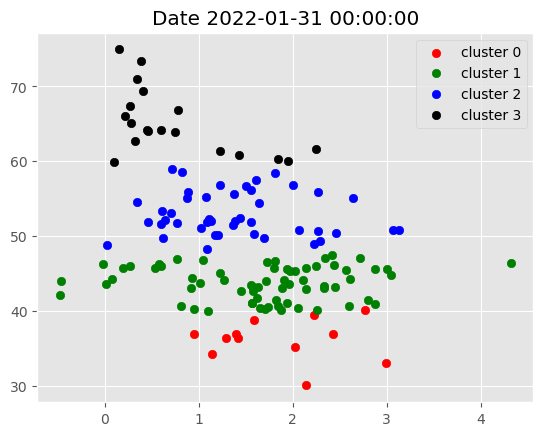

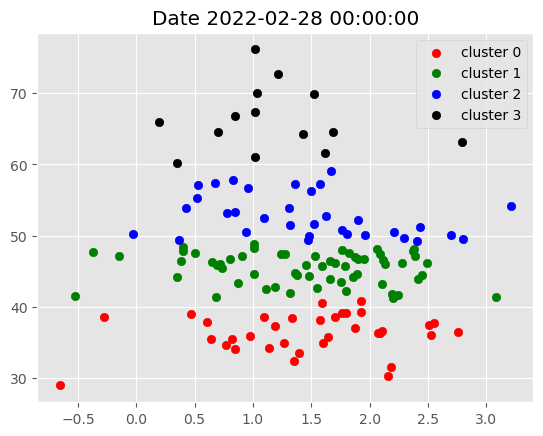

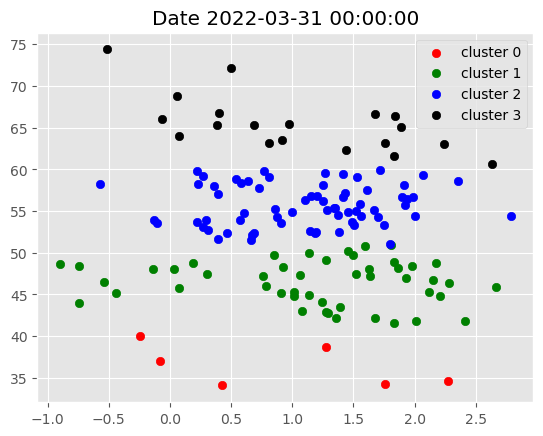

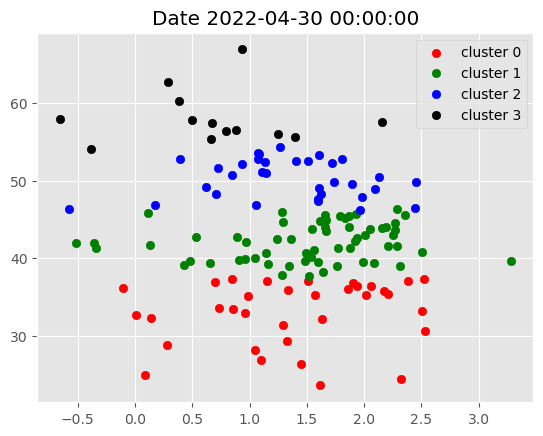

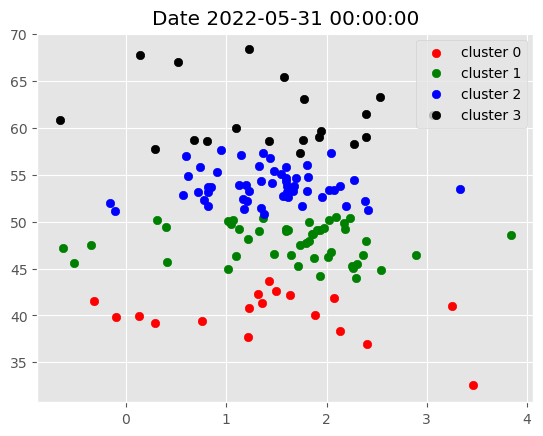

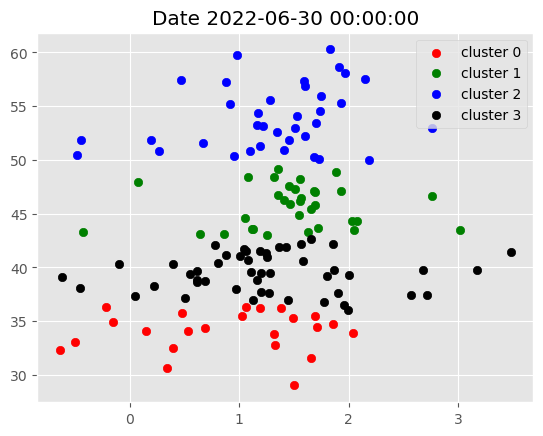

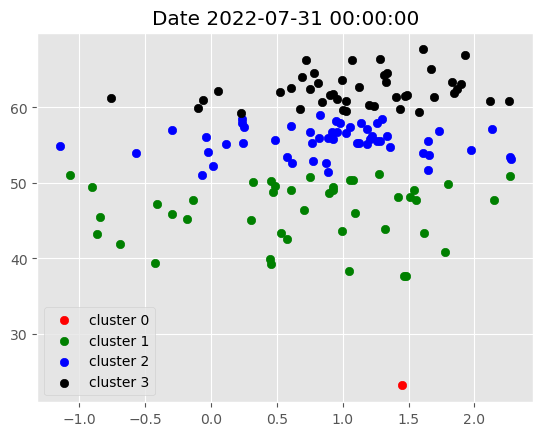

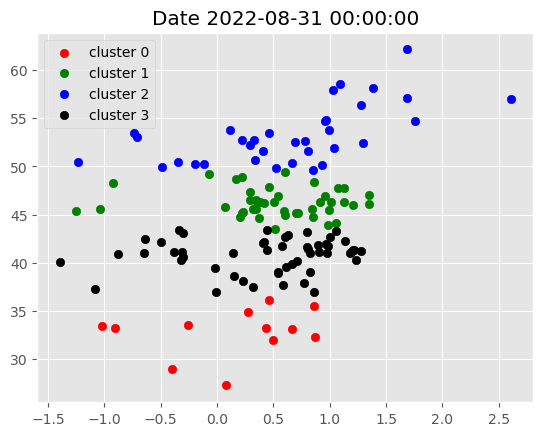

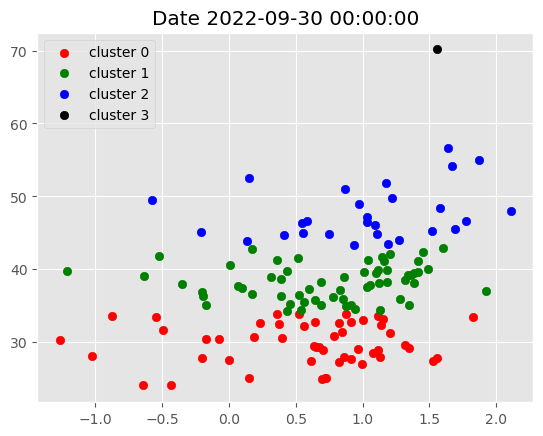

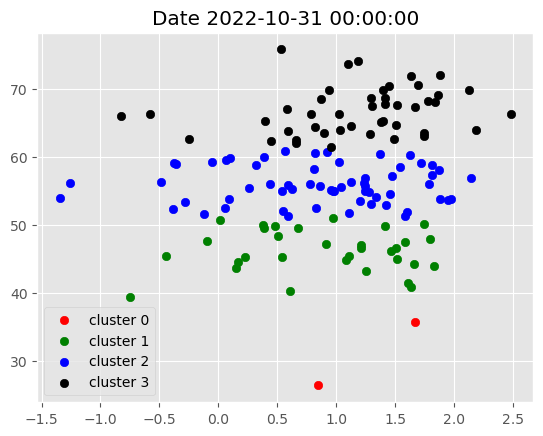

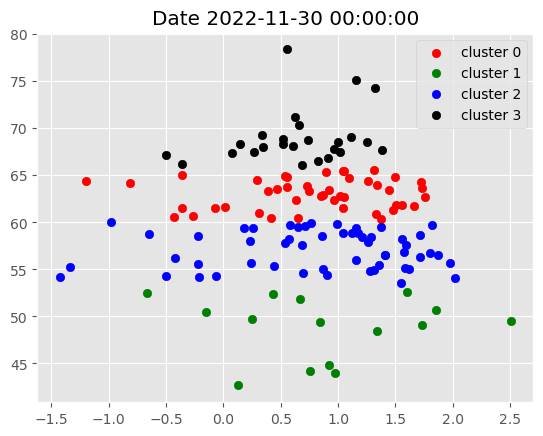

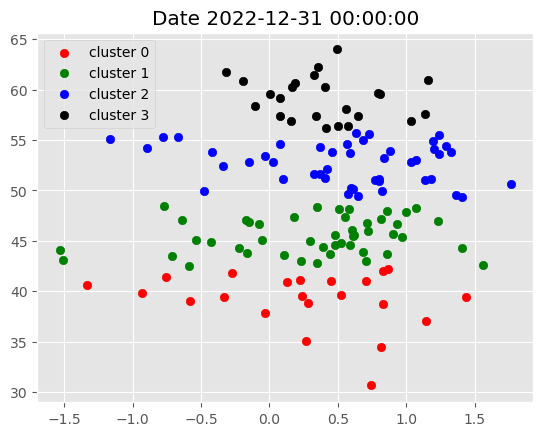

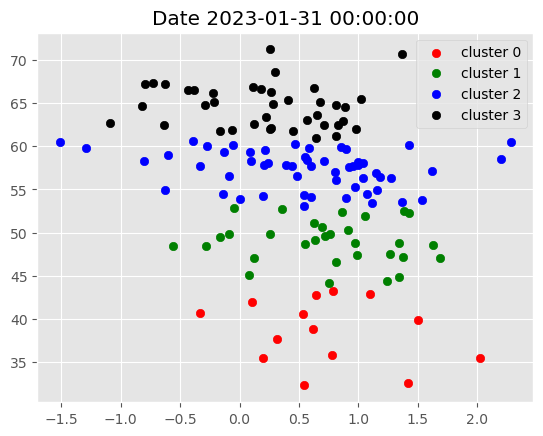

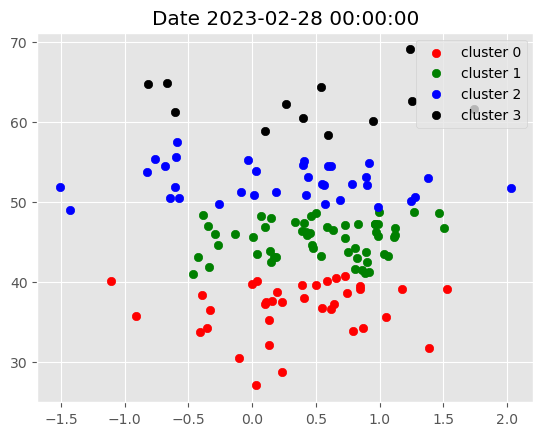

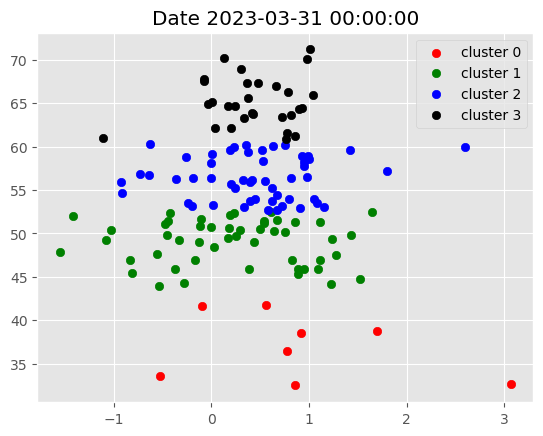

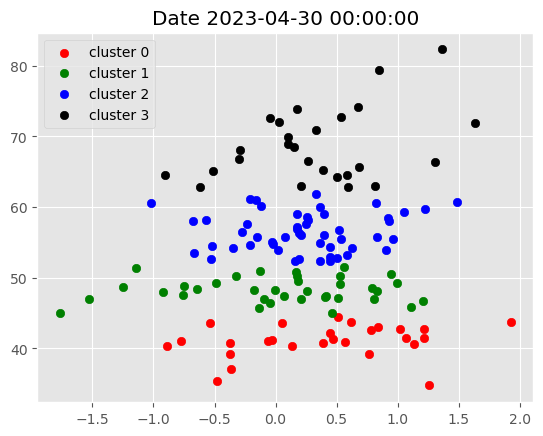

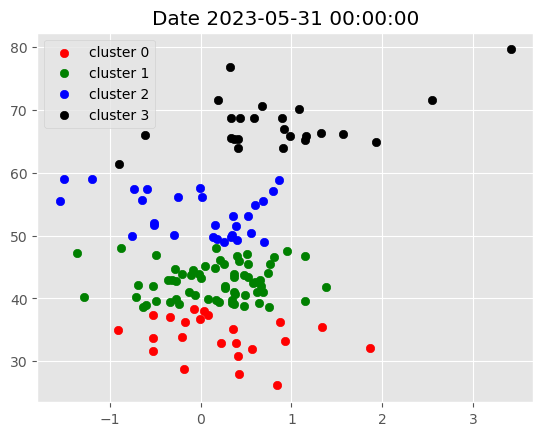

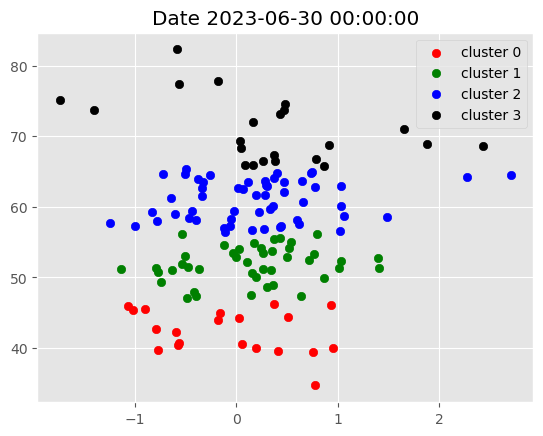

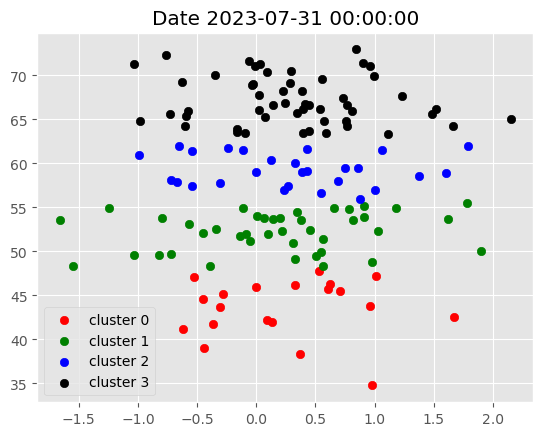

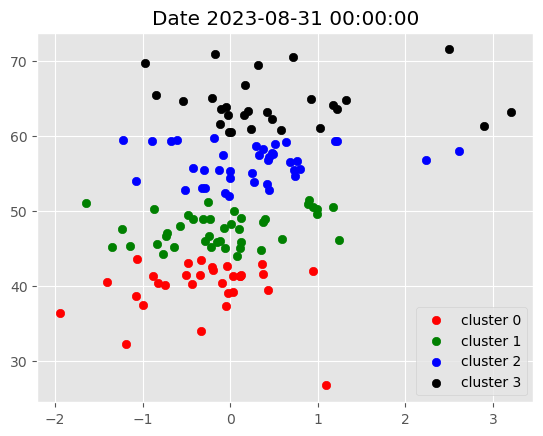

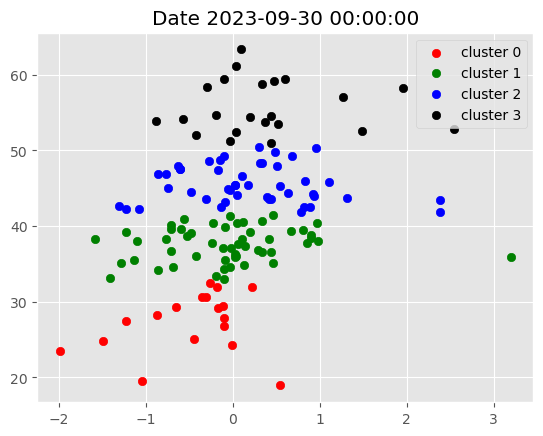

In [281]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0) #for each month, we select..''
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### 7 For each month, select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.
* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the fllowing month - thus I would selet stocks corresponding to cluster 3.

In [282]:
filtered_df = data[data['cluster']==3].copy() #select cluster =3

filtered_df = filtered_df.reset_index(level=1) #

filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date','ticker'])

#create dates objects

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'WYNN'],
 '2018-02-01': ['

### Define portfolio optimization function

* we will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.
* To optimize the weights of a given portfolio, we would need to supply last 1 year prices to the function.
* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [283]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [304]:
def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency = 252)
    cov = risk_models.sample_cov(prices = prices,
                                 frequency = 252)
    ef = EfficientFrontier(expected_returns = returns,
                          cov_matrix = cov,
                          weight_bounds = (lower_bound, .2),
                          solver = 'SCS')
    weights = ef.max_sharte()
    
    return ef.clean_weights()



* Download Fresh Daily Pries Data only for short listed stocks.

In [296]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start = data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=1),
                     end = data.index.get_level_values('date').unique()[-1])

data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=1)
data.index.get_level_values('date').unique()[-1]


[*********************100%%**********************]  154 of 154 completed


Timestamp('2023-09-30 00:00:00')

* Calculate daily returns for each stock which could land up in our portfolio
* Then loop over each month start, select the stocks for the month and calculate their weights for the next months.
* If the maximum sharpe ratio optimization fails for a given months, apply equally-weighted weights.
* Calculated each day portfolio return.

In [303]:
# returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date]
    
    
    optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimization_end_date   = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    
    print(start_date)
    print(end_date)
    print(cols)
    print(optimization_start_date)
    print(optimization_end_date)

2017-11-01
2017-11-30
['AAPL', 'ACN', 'ADBE', 'AMAT', 'AMZN', 'AVGO', 'AXP', 'BAC', 'CAT', 'COP', 'CRM', 'CTSH', 'DE', 'DHR', 'DLTR', 'ELV', 'EOG', 'GOOG', 'GOOGL', 'INTC', 'ISRG', 'JPM', 'MA', 'MAR', 'MCD', 'MET', 'META', 'MMM', 'MSFT', 'MU', 'NEE', 'NVDA', 'NXPI', 'ORCL', 'PYPL', 'SHW', 'STZ', 'TXN', 'UNH', 'V', 'VLO', 'WMT', 'XOM']
2016-11-01
2017-10-31
2017-12-01
2017-12-31
['AMZN', 'AXP', 'AZO', 'BA', 'BAC', 'BRK-B', 'CAT', 'COST', 'CSCO', 'DE', 'DLTR', 'ELV', 'HD', 'HON', 'ILMN', 'JPM', 'KR', 'LUV', 'MAR', 'MMM', 'NKE', 'ORLY', 'OXY', 'SCHW', 'UNH', 'UNP', 'VLO', 'VZ', 'WMT']
2016-12-01
2017-11-30
2018-01-01
2018-01-31
['ACN', 'BA', 'BAC', 'CAT', 'CSCO', 'CVX', 'DAL', 'DE', 'DG', 'EOG', 'FCX', 'FDX', 'HAL', 'HD', 'KR', 'LOW', 'LUV', 'MAR', 'OXY', 'PEP', 'PXD', 'RTX', 'STZ', 'T', 'TXN', 'UAL', 'UNP', 'VLO', 'VZ', 'WMT', 'WYNN']
2017-01-01
2017-12-31
2018-02-01
2018-02-28
['ABT', 'ADBE', 'AMZN', 'BA', 'BAC', 'BRK-B', 'CHTR', 'CRM', 'CTSH', 'DG', 'EA', 'GOOG', 'GOOGL', 'JPM', 'KR', 

In [ ]:
weights

In [286]:
new_df

Adj Close                                                 \
                  AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2017-10-02  46.419178   36.184799   67.127541  47.767899  121.928780   
2017-10-03  49.122829   36.342434   66.615128  47.830185  120.857521   
2017-10-04  49.336784   36.107166   66.763680  48.355206  121.676712   
2017-10-05  49.171452   36.556511   66.971596  48.871330  122.630966   
2017-10-06  49.891129   36.535351   67.201805  48.942513  122.657990   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.624237  150.264954  95.991318  313.318970   
2023-09-26  12.700000  171.514893  149.545944  94.770126  307.012848   
2023-09-27  12.610000  169.988846  148.788055  94.080750  310.739227   
2023-09-28  12.920000  170.248184  147.933014  96.631462  297.286804   
2023-09-29  12.810000  170.766846  144.833466  95.380714  303.553406   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-10-02  147.940002   95.353401  112.470001  51.913830   48.245003  ...   
2017-10-03  148.600006   96.565796  113.629997  51.720818   48.022667  ...   
2017-10-04  147.949997   97.167664  114.050003  51.678848   47.800350  ...   
2017-10-05  150.250000   99.060425  116.540001  52.014534   47.642860  ...   
2017-10-06  151.119995   98.981911  116.959999  52.249523   48.541439  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  237.203598  205.669998  61.502777  136.066559  ...   
2023-09-26  506.299988  234.456207  201.660004  60.641556  133.566162  ...   
2023-09-27  502.600006  239.782959  202.279999  60.394081  134.542404  ...   
2023-09-28  504.670013  240.454971  207.889999  60.661354  137.690292  ...   
2023-09-29  509.899994  237.757019  206.910004  59.988220  137.919418  ...   

             Volume                                                           \
                  V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                           
2017-10-02  4885600  3141300  2057700   9525800   5513900  7502300  11764400   
2017-10-03  4411100  3194700   995000  10218600   4934300  4576500  17405100   
2017-10-04  4146800  2669900   970200   9887500   4652600  3414300  14697800   
2017-10-05  4396100  4923400  1273700  12230600   4622700  5481400  14560700   
2017-10-06  4587000  4672400  1551100  13239600  11629900  3489900  11151200   
...             ...      ...      ...       ...       ...      ...       ...   
2023-09-25  5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26  6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27  6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28  4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29  6044200  4302200   896800  19759400  25659100  2512000  13119100   

                                         
                 WMT     WYNN       XOM  
Date                                     
2017-10-02  23127600  3006000   6777900  
2017-10-03  23810100  1709000   6082000  
2017-10-04  18520200  1525000   6357100  
2017-10-05  15416100  1718500   7375900  
2017-10-06  18740100  3339400   6070600  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1509 rows x 924 columns]

In [294]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:
    
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date   = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        
        success = False
        try: 
        
            weights = optimize_weights(prices = optimization_df,
                                       lower_bound = round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            Success = True
        except:
            print(f'Max  Share Optimization failed for {start_date}, continuing with Equal-Weights')
            
        if success == False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                   index=optimization_df.columns.tolist(),
                                   columns = pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                                 .merge(weights.stack().to_frame('weight').reset_index(level=0,drop=True),
                                       left_index=True,
                                       right_index=True)\
                                 .reset_index().set_index(['Date','index']).unstack().stack()

        temp_df.index.names = ['date','ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

Portfolio_df = portfolio_df.drop_duplicates()

Max  Share Optimization failed for 2017-11-01, continuing with Equal-Weights
Max  Share Optimization failed for 2017-12-01, continuing with Equal-Weights
Max  Share Optimization failed for 2018-01-01, continuing with Equal-Weights
Max  Share Optimization failed for 2018-02-01, continuing with Equal-Weights
Max  Share Optimization failed for 2018-03-01, continuing with Equal-Weights
Max  Share Optimization failed for 2018-04-01, continuing with Equal-Weights
Max  Share Optimization failed for 2018-05-01, continuing with Equal-Weights
Max  Share Optimization failed for 2018-06-01, continuing with Equal-Weights
Max  Share Optimization failed for 2018-07-01, continuing with Equal-Weights
Max  Share Optimization failed for 2018-08-01, continuing with Equal-Weights
Max  Share Optimization failed for 2018-09-01, continuing with Equal-Weights
Max  Share Optimization failed for 2018-10-01, continuing with Equal-Weights
Max  Share Optimization failed for 2018-11-01, continuing with Equal-Weights

* calculate optimized weights


In [295]:
returns_dataframe

,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADP,ADSK,AIG,AMAT,...,V,VLO,VRTX,VZ,WBA,WDC,WFC,WMT,WYNN,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-03,0.056611,0.004347,-0.007663,0.001303,-0.008825,0.004451,0.012635,0.010261,-0.003725,-0.004619,...,0.001422,0.006726,0.001838,0.009878,0.002477,-0.004688,0.001981,0.009767,0.000136,0.001591
2017-10-04,0.004346,-0.006495,0.002228,0.010917,0.006755,-0.004384,0.006213,0.003689,-0.000812,-0.004640,...,-0.002655,0.001546,0.000000,0.001002,-0.012580,0.016134,-0.011218,-0.001642,-0.000816,0.000367
2017-10-05,-0.003357,0.012368,0.003109,0.010617,0.007812,0.015426,0.019292,0.021598,0.006475,-0.003300,...,0.008792,-0.005421,-0.001378,-0.002609,0.014662,-0.009170,0.007793,0.004038,-0.000068,0.002808
2017-10-06,0.014530,-0.000579,0.003432,0.001455,0.000220,0.005774,-0.000793,0.003597,0.004508,0.018685,...,0.004602,-0.000517,0.018218,-0.007552,-0.049961,0.003225,0.003425,-0.005177,-0.020764,-0.003787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,0.000775,0.007353,0.012427,-0.006952,0.002843,-0.002538,0.002795,0.007957,0.008892,0.003080,...,-0.007344,0.008704,0.003256,-0.003612,0.010363,-0.011587,0.007972,0.004425,-0.009989,0.011161
2023-09-26,-0.016400,-0.023677,-0.004796,-0.012804,-0.020332,-0.010414,-0.011650,-0.019690,-0.014102,-0.018547,...,-0.016026,-0.034433,0.002904,-0.005140,-0.009889,-0.007875,-0.022139,-0.003501,0.000331,0.001547
2023-09-27,-0.007112,-0.008937,-0.005081,-0.007301,0.012064,-0.007335,0.022465,0.003070,-0.004089,0.007282,...,-0.000653,0.016601,-0.005817,-0.018046,-0.005219,0.006529,0.005153,-0.004812,0.016732,0.032039


In [239]:
optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

In [ ]:
cols